# 03 — Modeling (Ridge/LASSO, XGBoost) with Walk-Forward
Train models to predict next-month **excess returns**, generate out-of-sample predictions.

In [485]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from pathlib import Path
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

In [486]:
monthly_prices = pd.read_parquet('../data/prices_monthly.parquet')
X = pd.read_parquet('../data/features_monthly.parquet')


In [487]:
returns = monthly_prices.pct_change()
y = returns.sub(returns['SPY'],axis=0).shift(-1)
y.tail()

/var/folders/st/y2tgd9yj129138_bv71m8m040000gn/T/ipykernel_67156/3373578767.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = monthly_prices.pct_change()


Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,ZG,ZION,ZIP,ZM,ZS,ZTS,ZUMZ,ZVRA,ZWS,ZYME
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-30,-0.048099,-0.007444,0.001033,0.162837,-0.132802,0.109172,0.123313,-0.011334,-0.059487,0.004081,...,0.097570,0.009313,-0.184708,-0.073429,-0.113431,-0.085055,0.010905,0.238035,0.186977,-0.022235
2025-07-31,0.073984,0.057229,0.143101,0.199150,0.037635,-0.027106,0.128717,0.099119,0.077746,0.092590,...,0.041109,0.070468,0.169957,0.079008,-0.050321,0.052256,0.233310,-0.204138,0.006608,0.158621
2025-08-31,-0.012162,-0.013874,-0.194932,-0.090555,0.035867,0.092227,-0.028898,0.061261,-0.047262,0.064855,...,-0.122022,-0.060271,-0.191620,-0.022356,0.045990,-0.100070,0.105159,0.012891,0.001196,0.117654
2025-09-30,0.116482,0.094740,0.144312,-0.025083,0.347547,0.029138,-0.252415,0.037978,-0.083385,-0.075354,...,-0.062929,-0.102841,0.078058,0.033496,0.081215,-0.039078,0.080191,0.046615,-0.022136,0.093551
2025-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [488]:
y = y.drop(columns='SPY')
y.tail()

Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,ZG,ZION,ZIP,ZM,ZS,ZTS,ZUMZ,ZVRA,ZWS,ZYME
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-30,-0.048099,-0.007444,0.001033,0.162837,-0.132802,0.109172,0.123313,-0.011334,-0.059487,0.004081,...,0.097570,0.009313,-0.184708,-0.073429,-0.113431,-0.085055,0.010905,0.238035,0.186977,-0.022235
2025-07-31,0.073984,0.057229,0.143101,0.199150,0.037635,-0.027106,0.128717,0.099119,0.077746,0.092590,...,0.041109,0.070468,0.169957,0.079008,-0.050321,0.052256,0.233310,-0.204138,0.006608,0.158621
2025-08-31,-0.012162,-0.013874,-0.194932,-0.090555,0.035867,0.092227,-0.028898,0.061261,-0.047262,0.064855,...,-0.122022,-0.060271,-0.191620,-0.022356,0.045990,-0.100070,0.105159,0.012891,0.001196,0.117654
2025-09-30,0.116482,0.094740,0.144312,-0.025083,0.347547,0.029138,-0.252415,0.037978,-0.083385,-0.075354,...,-0.062929,-0.102841,0.078058,0.033496,0.081215,-0.039078,0.080191,0.046615,-0.022136,0.093551
2025-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [489]:
X, y = X.align(y, join='inner', axis=0)

In [490]:
X.tail()

,mom_1m__A,mom_1m__AA,mom_1m__AAL,mom_1m__AAMI,mom_1m__AAOI,mom_1m__AAON,mom_1m__AAP,mom_1m__AAPL,mom_1m__AAT,mom_1m__ABBV,...,beta_24m__ZG,beta_24m__ZION,beta_24m__ZIP,beta_24m__ZM,beta_24m__ZS,beta_24m__ZTS,beta_24m__ZUMZ,beta_24m__ZVRA,beta_24m__ZWS,beta_24m__ZYME
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-30,-0.049419,0.124755,-0.307616,0.373234,2.172669,-1.094658,-0.356271,-0.168971,-0.220252,-0.256682,...,2.430737,1.901591,1.621839,1.019956,1.553613,1.098820,0.990993,1.631567,1.233384,1.264668
2025-07-31,-0.313940,-0.165358,-0.134381,0.456958,-0.623500,0.260831,0.312511,-0.179576,-0.355560,-0.123240,...,2.440343,1.715085,1.561473,0.976773,1.505569,1.043574,0.937449,1.734127,1.226557,1.350607
2025-08-31,0.023469,-0.036853,0.272299,0.474085,-0.107394,-0.340475,0.220516,0.113958,0.037012,0.090452,...,2.450951,1.692353,1.510195,0.982606,1.487521,1.105470,1.007835,1.756846,1.221617,1.351478
2025-09-30,-0.233557,-0.239373,-0.854459,-0.499871,-0.070392,0.121072,-0.290411,0.015875,-0.352797,0.028085,...,2.380600,1.796391,1.254615,1.066995,1.646200,1.036480,1.062832,1.811914,1.225127,1.224517
2025-10-31,0.152122,0.082106,0.241743,-0.303759,0.896220,-0.129152,-1.035835,-0.100684,-0.491507,-0.465646,...,2.149279,1.677531,1.225033,0.893262,1.739927,0.956747,0.992767,1.757298,1.175445,1.409002


In [491]:
y.tail()

Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,ZG,ZION,ZIP,ZM,ZS,ZTS,ZUMZ,ZVRA,ZWS,ZYME
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-30,-0.048099,-0.007444,0.001033,0.162837,-0.132802,0.109172,0.123313,-0.011334,-0.059487,0.004081,...,0.097570,0.009313,-0.184708,-0.073429,-0.113431,-0.085055,0.010905,0.238035,0.186977,-0.022235
2025-07-31,0.073984,0.057229,0.143101,0.199150,0.037635,-0.027106,0.128717,0.099119,0.077746,0.092590,...,0.041109,0.070468,0.169957,0.079008,-0.050321,0.052256,0.233310,-0.204138,0.006608,0.158621
2025-08-31,-0.012162,-0.013874,-0.194932,-0.090555,0.035867,0.092227,-0.028898,0.061261,-0.047262,0.064855,...,-0.122022,-0.060271,-0.191620,-0.022356,0.045990,-0.100070,0.105159,0.012891,0.001196,0.117654
2025-09-30,0.116482,0.094740,0.144312,-0.025083,0.347547,0.029138,-0.252415,0.037978,-0.083385,-0.075354,...,-0.062929,-0.102841,0.078058,0.033496,0.081215,-0.039078,0.080191,0.046615,-0.022136,0.093551
2025-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [492]:
def reshape_col_to_multindex(X_flat: pd.DataFrame) -> pd.DataFrame:
    features,tickers = zip(*[c.split("__", 1) for c in X_flat.columns])
    X_mi = X_flat.copy()
    X_mi.columns = pd.MultiIndex.from_arrays([features, tickers], names=["feature","ticker"])
    return X_mi

X_mi = reshape_col_to_multindex(X)
X_mi

feature       mom_1m                                                    \
ticker             A        AA       AAL      AAMI      AAOI      AAON   
Date                                                                     
2015-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2015-02-28  0.795056 -0.360097 -0.149234  1.249170  2.678112  0.217072   
2015-03-31 -0.138989 -1.330154  1.071797  0.398319  1.180164  0.944070   
2015-04-30 -0.197766  0.102164 -0.747438  0.101654  0.033291 -0.326692   
2015-05-31 -0.106823 -0.636126 -1.113680 -0.021388  2.065007 -0.176348   
...              ...       ...       ...       ...       ...       ...   
2025-06-30 -0.049419  0.124755 -0.307616  0.373234  2.172669 -1.094658   
2025-07-31 -0.313940 -0.165358 -0.134381  0.456958 -0.623500  0.260831   
2025-08-31  0.023469 -0.036853  0.272299  0.474085 -0.107394 -0.340475   
2025-09-30 -0.233557 -0.239373 -0.854459 -0.499871 -0.070392  0.121072   
2025-10-31  0.152122  0.082106  0.241743 -0.303759  0.896220 -0.129152   

feature                                             ...  beta_24m            \
ticker           AAP      AAPL       AAT      ABBV  ...        ZG      ZION   
Date                                                ...                       
2015-01-31       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2015-02-28 -0.173127  0.681587 -0.512054  0.016811  ...       NaN       NaN   
2015-03-31 -0.351745 -0.330039  0.643261 -0.340821  ...       NaN       NaN   
2015-04-30 -0.479079 -0.127241 -0.728006  0.624949  ...       NaN       NaN   
2015-05-31  0.538801  0.316300 -0.166052  0.184393  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2025-06-30 -0.356271 -0.168971 -0.220252 -0.256682  ...  2.430737  1.901591   
2025-07-31  0.312511 -0.179576 -0.355560 -0.123240  ...  2.440343  1.715085   
2025-08-31  0.220516  0.113958  0.037012  0.090452  ...  2.450951  1.692353   
2025-09-30 -0.290411  0.015875 -0.352797  0.028085  ...  2.380600  1.796391   
2025-10-31 -1.035835 -0.100684 -0.491507 -0.465646  ...  2.149279  1.677531   

feature                                                                 \
ticker           ZIP        ZM        ZS       ZTS      ZUMZ      ZVRA   
Date                                                                     
2015-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2015-02-28       NaN       NaN       NaN       NaN       NaN       NaN   
2015-03-31       NaN       NaN       NaN       NaN       NaN       NaN   
2015-04-30       NaN       NaN       NaN       NaN       NaN       NaN   
2015-05-31       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2025-06-30  1.621839  1.019956  1.553613  1.098820  0.990993  1.631567   
2025-07-31  1.561473  0.976773  1.505569  1.043574  0.937449  1.734127   
2025-08-31  1.510195  0.982606  1.487521  1.105470  1.007835  1.756846   
2025-09-30  1.254615  1.066995  1.646200  1.036480  1.062832  1.811914   
2025-10-31  1.225033  0.893262  1.739927  0.956747  0.992767  1.757298   

feature                         
ticker           ZWS      ZYME  
Date                            
2015-01-31       NaN       NaN  
2015-02-28       NaN       NaN  
2015-03-31       NaN       NaN  
2015-04-30       NaN       NaN  
2015-05-31       NaN       NaN  
...              ...       ...  
2025-06-30  1.233384  1.264668  
2025-07-31  1.226557  1.350607  
2025-08-31  1.221617  1.351478  
2025-09-30  1.225127  1.224517  
2025-10-31  1.175445  1.409002  

[130 rows x 20439 columns]

In [493]:
X_tidy = X_mi.stack('ticker', future_stack=True)
assert X_tidy.index.nlevels == 2 and X_tidy.index.names == ['Date','ticker']
X_tidy.tail()

feature              mom_1m    mom_3m    mom_6m   mom_12m    rev_1m    vol_6m  \
Date       ticker                                                               
2025-10-31 ZTS    -0.348827 -0.322015 -0.512078 -0.904182 -0.250668 -0.073988   
           ZUMZ    0.035255  1.306012  1.831265  0.208029 -0.634750 -0.043750   
           ZVRA   -0.072871 -0.507954  0.966669  0.690132 -0.526624  0.182307   
           ZWS    -0.294269 -0.088352  0.841486  0.715411 -0.305225 -0.050171   
           ZYME    0.078279  1.148752  1.075779  0.959022 -0.677774  0.062609   

feature            idvol_6m  beta_24m  
Date       ticker                      
2025-10-31 ZTS    -0.112015  0.956747  
           ZUMZ   -0.056242  0.992767  
           ZVRA    0.228472  1.757298  
           ZWS    -0.020123  1.175445  
           ZYME    0.089868  1.409002

In [494]:
y_tidy = y.stack().rename('target')          # Series with (date, ticker) index
assert y_tidy.index.nlevels == 2
y_tidy.tail()

Date        Ticker
2025-09-30  ZTS      -0.039078
            ZUMZ      0.080191
            ZVRA      0.046615
            ZWS      -0.022136
            ZYME      0.093551
Name: target, dtype: float64

In [495]:
X_tidy = X_tidy.drop(index='SPY', level='ticker', errors='ignore')
y_tidy = y_tidy.drop(index='SPY', level=1,        errors='ignore')

# 1) Force identical index names
X_tidy.index = X_tidy.index.set_names(['Date', 'Ticker'])
y_tidy.index = y_tidy.index.set_names(['Date', 'Ticker'])

In [496]:
xy   = X_tidy.join(y_tidy, how="inner").dropna()
xy

mom_1m    mom_3m    mom_6m   mom_12m    rev_1m    vol_6m  \
Date       Ticker                                                               
2017-01-31 A      -0.165773  0.055671 -0.372265  0.837168 -0.851575 -0.273094   
           AA      0.856939  1.926845  1.477812  3.525542 -1.874288  0.240661   
           AAL    -0.748097 -0.051203  0.604499  0.440637 -0.269251 -0.171660   
           AAMI   -0.635058 -0.492252 -0.464037  0.651706 -0.382291 -0.360003   
           AAOI    0.922039  1.995910  4.777142  3.584366 -1.939387  0.535615   
...                     ...       ...       ...       ...       ...       ...   
2025-09-30 ZTS    -0.532196 -0.495667 -0.644797 -1.180375 -0.094299 -0.069795   
           ZUMZ    0.165005  1.142598  0.853610 -0.242628 -0.791501  0.213029   
           ZVRA   -0.148445  0.114661  0.710822  1.083969 -0.478051  0.208997   
           ZWS    -0.188175  0.617416  0.985840  0.767016 -0.438320 -0.061434   
           ZYME    0.207454  0.818732  1.052805  0.927168 -0.833950  0.063568   

                   idvol_6m  beta_24m    target  
Date       Ticker                                
2017-01-31 A      -0.278858  1.616526  0.008289  
           AA      0.145970  1.050300 -0.090320  
           AAL    -0.168967  1.011159  0.010722  
           AAMI   -0.309846  1.760375  0.018155  
           AAOI    0.457227  1.223062  0.453556  
...                     ...       ...       ...  
2025-09-30 ZTS    -0.118715  1.036480 -0.039078  
           ZUMZ    0.128823  1.062832  0.080191  
           ZVRA    0.240646  1.811914  0.046615  
           ZWS    -0.018662  1.225127 -0.022136  
           ZYME    0.095801  1.224517  0.093551  

[207860 rows x 9 columns]

In [497]:
Xmat = xy.drop(columns="target")
yvec = xy["target"]
Xmat

mom_1m    mom_3m    mom_6m   mom_12m    rev_1m    vol_6m  \
Date       Ticker                                                               
2017-01-31 A      -0.165773  0.055671 -0.372265  0.837168 -0.851575 -0.273094   
           AA      0.856939  1.926845  1.477812  3.525542 -1.874288  0.240661   
           AAL    -0.748097 -0.051203  0.604499  0.440637 -0.269251 -0.171660   
           AAMI   -0.635058 -0.492252 -0.464037  0.651706 -0.382291 -0.360003   
           AAOI    0.922039  1.995910  4.777142  3.584366 -1.939387  0.535615   
...                     ...       ...       ...       ...       ...       ...   
2025-09-30 ZTS    -0.532196 -0.495667 -0.644797 -1.180375 -0.094299 -0.069795   
           ZUMZ    0.165005  1.142598  0.853610 -0.242628 -0.791501  0.213029   
           ZVRA   -0.148445  0.114661  0.710822  1.083969 -0.478051  0.208997   
           ZWS    -0.188175  0.617416  0.985840  0.767016 -0.438320 -0.061434   
           ZYME    0.207454  0.818732  1.052805  0.927168 -0.833950  0.063568   

                   idvol_6m  beta_24m  
Date       Ticker                      
2017-01-31 A      -0.278858  1.616526  
           AA      0.145970  1.050300  
           AAL    -0.168967  1.011159  
           AAMI   -0.309846  1.760375  
           AAOI    0.457227  1.223062  
...                     ...       ...  
2025-09-30 ZTS    -0.118715  1.036480  
           ZUMZ    0.128823  1.062832  
           ZVRA    0.240646  1.811914  
           ZWS    -0.018662  1.225127  
           ZYME    0.095801  1.224517  

[207860 rows x 8 columns]

In [498]:
yvec

Date        Ticker
2017-01-31  A         0.008289
            AA       -0.090320
            AAL       0.010722
            AAMI      0.018155
            AAOI      0.453556
                        ...   
2025-09-30  ZTS      -0.039078
            ZUMZ      0.080191
            ZVRA      0.046615
            ZWS      -0.022136
            ZYME      0.093551
Name: target, Length: 207860, dtype: float64

In [499]:
ridge = Ridge(alpha=1.0)
ridge.fit(Xmat.values, yvec.values)

preds_in_sample = pd.Series(ridge.predict(Xmat.values), index=Xmat.index, name="score")
preds_in_sample

Date        Ticker
2017-01-31  A        -0.015863
            AA       -0.025782
            AAL      -0.011318
            AAMI     -0.009807
            AAOI     -0.025862
                        ...   
2025-09-30  ZTS      -0.001362
            ZUMZ     -0.013348
            ZVRA      0.001838
            ZWS      -0.012493
            ZYME     -0.012118
Name: score, Length: 207860, dtype: float64

In [500]:
preds_in_sample.to_frame().to_parquet("../data/scores_in_sample.parquet")

In [501]:
window = 36
dates = X_tidy.index.get_level_values(0).unique().sort_values()
dates

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31',
               ...
               '2025-01-31', '2025-02-28', '2025-03-31', '2025-04-30',
               '2025-05-31', '2025-06-30', '2025-07-31', '2025-08-31',
               '2025-09-30', '2025-10-31'],
              dtype='datetime64[ns]', name='Date', length=130, freq=None)

In [502]:
scores = []
for i in range(window,len(dates)):
    dt = dates[i]
    
    train_range = dates[i-window:i]
    #train_idx   = xy.index.get_level_values(0).isin(train_range)

    X_train = X_tidy.loc[train_range]
    y_train = y_tidy.loc[train_range]

    train = X_train.join(y_train, how='inner').dropna()
    if train.empty:
        continue
    
    X_train = train.drop(columns='target')
    y_train = train['target']

    if dt not in X_tidy.index.get_level_values(0):
        continue
    
    X_pred = X_tidy.loc[dt].reindex(columns=X_train.columns).dropna()
    if X_pred.empty:
        continue
    
   # m = X_train.notna().all(axis=1) & y_train.notna()
    #X_train = X_train.loc[m]
    #y_train = y_train.loc[m]

   # if len(X_train) == 0:
   #     continue 
    
  #  X_pred = X_tidy.loc[dt]                
  #  X_pred = X_pred.reindex(columns=X_train.columns)

 #   X_pred = X_pred.dropna()
 #   if X_pred.empty:
  #      continue 

    tickers_dt = X_pred.index


    model = Ridge(alpha=1)
    model.fit(X_train.values, y_train.values)

    s = pd.Series(model.predict(X_pred.values), index=tickers_dt, name=dt)
    scores.append(s)


In [503]:
scores = pd.concat(scores, axis=1).T
scores

Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,DBD,LLYVA,LLYVK,CART,SEZL,VSTS,BIRK,NATL,NLOP,VLTO
2018-01-31,0.006723,0.017554,0.005159,0.003507,0.027474,0.000177,0.009807,0.012316,0.006229,0.003481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,0.021075,0.032204,0.016450,0.019595,0.028341,0.014231,0.029441,0.025566,0.013128,0.023277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-31,0.029958,0.043219,0.029537,0.029078,0.045057,0.022420,0.036312,0.029402,0.026040,0.039683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-30,0.022107,0.040957,0.025543,0.022174,0.044589,0.016495,0.023209,0.022178,0.018718,0.035653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31,0.010211,0.021443,0.015531,0.010107,0.036842,0.010401,0.011173,0.014211,0.008824,0.022709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.005334,-0.002401,-0.001603,-0.012382,0.030871,0.003954,-0.001255,-0.005023,-0.008093,-0.003149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-31,-0.008470,-0.007241,-0.000636,-0.016227,0.011485,0.013734,-0.001667,-0.006426,-0.011027,-0.003591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-31,-0.012684,-0.008704,-0.002462,-0.022707,0.010652,-0.001647,-0.005567,-0.010275,-0.011805,-0.010131,...,-0.017726,-0.012367,-0.012151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-09-30,-0.017094,-0.012427,-0.010842,-0.019854,0.011252,-0.007415,-0.006646,-0.014860,-0.016819,-0.013941,...,-0.016026,-0.016508,-0.016677,-0.007661,0.034839,0.001062,NaN,NaN,NaN,NaN


In [504]:
scores.to_parquet("../data/scores_walkforward.parquet")


In [505]:
ic = []
for dt in scores.index:
    if dt in y.index:
        s = scores.loc[dt].dropna()
        r = y.loc[dt].reindex(s.index).dropna()
        s, r = s.align(r, join="inner")
        if len(s) > 1:
            ic.append(s.corr(r, method="spearman"))

ic = pd.Series(ic, index=scores.index[:len(ic)], name="IC")
print("Mean IC:", ic.mean().round(4))
print("Std Dev:", ic.std(ddof=1).round(4))



Mean IC: -0.0146
Std Dev: 0.1256


Mean IC:  -0.0146
IC stdev: 0.126
IC t-stat:-1.08   (N=87)
Hit ratio:42.53%


/var/folders/st/y2tgd9yj129138_bv71m8m040000gn/T/ipykernel_67156/675859704.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax = ic.plot(title="Monthly IC"); ax.figure.show()
/var/folders/st/y2tgd9yj129138_bv71m8m040000gn/T/ipykernel_67156/675859704.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax = ic_12m.plot(title="12m Rolling IC"); ax.figure.show()


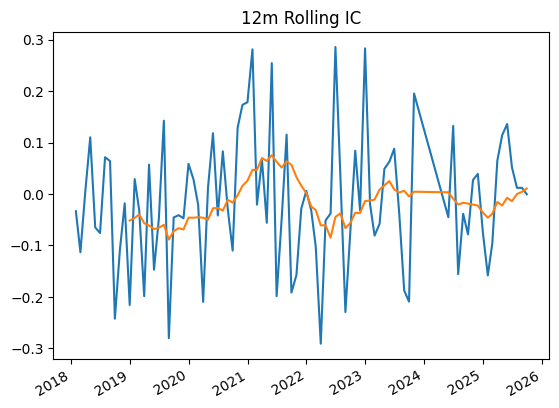

In [506]:
N = ic.notna().sum()
ic_mean = ic.mean()
ic_std  = ic.std(ddof=1)
ic_t    = ic_mean / (ic_std / np.sqrt(N))
ic_hit  = (ic > 0).mean()

print(f"Mean IC:  {ic_mean:.4f}")
print(f"IC stdev: {ic_std:.3f}")
print(f"IC t-stat:{ic_t:.2f}   (N={N})")
print(f"Hit ratio:{ic_hit:.2%}")

# rolling IC (12m)
ic_12m = ic.rolling(12).mean()
ax = ic.plot(title="Monthly IC"); ax.figure.show()
ax = ic_12m.plot(title="12m Rolling IC"); ax.figure.show()

Avg monthly turnover: 0.52
Avg monthly L–S: 0.0179
Sharpe (monthly): 0.18


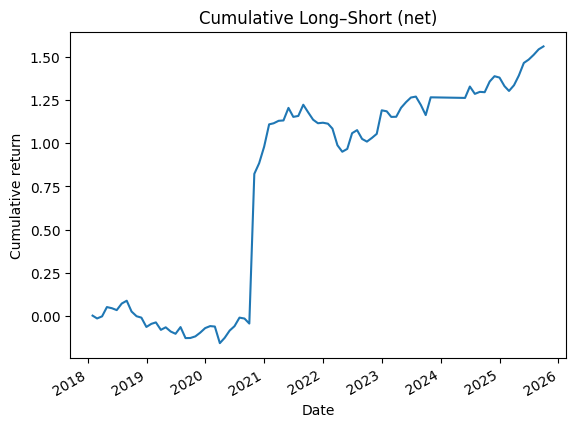

Max drawdown: -0.272


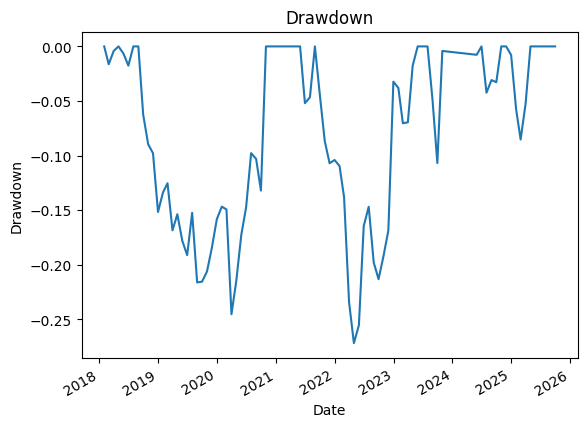

In [507]:
ls = []
for dt in scores.index[:-1]:
    if dt not in y.index:
        continue

    preds = scores.loc[dt].dropna()
    rets  = y.loc[dt].reindex(preds.index).dropna()
    preds, rets = preds.align(rets, join="inner")

    n = len(preds)
    if n < 10:
        continue

    q = int(0.2 * n)                 # top/bottom 20%
    long_names  = preds.nlargest(q).index
    short_names = preds.nsmallest(q).index

    long_ret  = rets.loc[long_names].mean()
    short_ret = rets.loc[short_names].mean()
    spread    = long_ret - short_ret

    ls.append((dt, spread, set(long_names) | set(short_names)))

ls = pd.DataFrame(ls, columns=["Date", "L_S", "names"]).set_index("Date").sort_index()
ls["L_S"] = ls["L_S"].astype(float)   # ensure it's a Series of floats

# --- Turnover (fraction of names that changed) ---
turn = []
prev = set()
for dt, names in ls["names"].items():
    cur = names
    chg = 0 if not prev else 1 - len(prev & cur) / len(prev | cur)
    turn.append((dt, chg))
    prev = cur

turn = pd.Series(dict(turn)).sort_index()

# --- Apply simple costs (align indices!) ---
cost_bps = 0.001   # 10 bps
net_ls = ls["L_S"] - cost_bps * turn.reindex(ls.index).fillna(0)

# --- Performance stats ---
sr_denom = net_ls.std(ddof=1)
sr = np.nan if sr_denom == 0 else net_ls.mean() / sr_denom

print("Avg monthly turnover:", turn.mean().round(2))
print("Avg monthly L–S:", net_ls.mean().round(4))
print("Sharpe (monthly):", round(sr, 2))

# --- Plot cumulative return ---
ax = net_ls.cumsum().plot(title="Cumulative Long–Short (net)")
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative return")
plt.show()

# --- Drawdown plot ---
cum  = net_ls.cumsum()
peak = cum.cummax()
dd   = cum - peak
print("Max drawdown:", dd.min().round(3))

ax = dd.plot(title="Drawdown")
ax.set_xlabel("Date"); ax.set_ylabel("Drawdown")
plt.show()

In [508]:
# pick all months and average by quintile
import pandas as pd
bins_all = []
for dt in scores.index[:-1]:
    if dt not in y.index: 
        continue
    preds = scores.loc[dt].dropna()
    rets  = y.loc[dt].reindex(preds.index).dropna()
    preds, rets = preds.align(rets, join="inner")
    if len(preds) < 10: 
        continue
    qbin = pd.qcut(preds, 5, labels=False, duplicates="drop")
    bins_all.append(rets.groupby(qbin).mean())

bin_table = pd.concat(bins_all, axis=1).mean(axis=1).rename({0:"Q1(low)",1:"Q2",2:"Q3",3:"Q4",4:"Q5(high)"})
bin_table


Q1(low)    -0.001193
Q2         -0.001145
Q3         -0.000613
Q4          0.001213
Q5(high)    0.017163
dtype: float64

In [509]:
scores.to_parquet("../data/scores_walkforward.parquet")
ic.to_frame("IC").to_parquet("../data/ic.parquet")
ls["L_S"].to_frame().to_parquet("../data/long_short_monthly.parquet")
net_ls.to_frame("L_S_net").to_parquet("../data/long_short_monthly_net.parquet")
turn.to_frame("turnover").to_parquet("../data/turnover.parquet")
print("✅ Saved artifacts")

✅ Saved artifacts


In [510]:
summary = pd.Series({
    "IC_mean": ic.mean(),
    "IC_std": ic.std(ddof=1),
    "IC_tstat": ic.mean() / (ic.std(ddof=1) / np.sqrt(ic.notna().sum())),
    "IC_hit_ratio": (ic > 0).mean(),
    "LS_mean": net_ls.mean(),
    "LS_std": net_ls.std(ddof=1),
    "LS_sharpe_m": net_ls.mean() / net_ls.std(ddof=1),
    "Turnover_m": turn.mean(),
    "MaxDD": (net_ls.cumsum() - net_ls.cumsum().cummax()).min(),
})
summary.round(3)

IC_mean        -0.015
IC_std          0.126
IC_tstat       -1.081
IC_hit_ratio    0.425
LS_mean         0.018
LS_std          0.102
LS_sharpe_m     0.175
Turnover_m      0.518
MaxDD          -0.272
dtype: float64

In [512]:
scores_xgb = []

for i in range(window, len(dates)):
    dt = dates[i]
    train_range = dates[i-window:i]
  #  train_idx   = xy.index.get_level_values(0).isin(train_range)

    X_train = X_tidy.loc[train_range]
    y_train = y_tidy.loc[train_range]

    # keep rows where all features are present & y is present
    m = X_train.notna().all(axis=1) & y_train.notna()
    X_train, y_train = X_train.loc[m], y_train.loc[m]
    if len(X_train) == 0:
        continue

    # predict cross-section at dt; align columns to training set
    X_pred = X_tidy.loc[dt].reindex(columns=X_train.columns)
    # If a row is all-NaN, drop just that row
    X_pred = X_pred.dropna(how="all")
    if X_pred.empty:
        continue

    # (optional) smaller dtype
    X_train = X_train.astype(np.float32)
    X_pred  = X_pred.astype(np.float32)

    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,     # L1
        reg_lambda=1.0,    # L2
        objective="reg:squarederror",
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
        eval_metric="rmse"
    )
    model.fit(X_train, y_train)

    s = pd.Series(model.predict(X_pred), index=X_pred.index, name=dt)
    scores_xgb.append(s)

scores_xgb = pd.concat(scores_xgb, axis=1).T.sort_index()


In [513]:
scores_xgb

Ticker,A,AA,AAL,AAMI,AAOI,AAON,AAP,AAPL,AAT,ABBV,...,SNDK,TIC,SMA,CMDB,STRZ,CRCL,RAL,AEBI,GLIBA,GLIBK
2018-01-31,-0.004798,0.023646,-0.006116,-0.005364,0.077913,-0.000022,-0.005551,0.006832,-0.005820,-0.005689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,0.048413,0.028966,0.003034,0.022546,0.022262,0.001103,0.024518,-0.002285,0.011052,-0.001081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-31,0.031389,0.029908,0.035416,0.007399,0.089673,0.000530,0.013698,0.038457,-0.004073,0.026909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-30,0.011984,0.012762,0.027218,0.021186,0.019174,0.019062,0.024806,0.014071,0.005079,0.005445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31,0.017980,0.030529,-0.004019,-0.000131,0.010656,0.010971,-0.001194,-0.000711,-0.003696,0.001300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.008707,-0.011142,-0.005634,-0.013129,0.119900,-0.004375,0.001416,-0.005302,-0.007690,-0.007013,...,0.091792,0.059324,0.020562,0.019507,-0.054605,NaN,NaN,NaN,NaN,NaN
2025-07-31,-0.011733,-0.012503,-0.005846,-0.012737,0.019042,0.008749,0.002950,-0.007431,-0.009202,-0.007069,...,0.052077,0.042544,0.047224,0.032606,0.010714,0.020454,0.013789,NaN,NaN,NaN
2025-08-31,-0.018741,-0.007344,-0.007735,-0.008989,0.051827,-0.006354,-0.006065,-0.010524,-0.009228,-0.011584,...,0.076944,0.338619,0.070029,0.085945,0.060851,-0.044548,0.018405,0.061030,0.075429,0.054792
2025-09-30,-0.016305,-0.007810,-0.021411,-0.005556,0.062218,-0.014666,0.000370,-0.012701,-0.011973,-0.008795,...,0.115969,0.116029,0.062847,0.107654,0.073629,0.071039,0.065392,0.019762,0.019762,0.024636


In [514]:
ic_pairs = []

for dt in scores_xgb.index.intersection(y.index):
    s = scores_xgb.loc[dt]             # predictions by ticker
    r = y.loc[dt].reindex(s.index)     # realized returns aligned to the same tickers
    m = s.notna() & r.notna()          # tickers with both values
    if m.sum() >= 3:
        ic = s[m].corr(r[m], method="spearman")
        ic_pairs.append((dt, ic))

ic_xgb = pd.Series(dict(ic_pairs)).sort_index()
print("Mean IC:", ic_xgb.mean().round(4))
print("Std Dev:", ic_xgb.std(ddof=1).round(4))


Mean IC: -0.0079
Std Dev: 0.0923


Avg monthly turnover: 0.58
Avg monthly L–S: 0.0138
Sharpe (monthly): 0.16


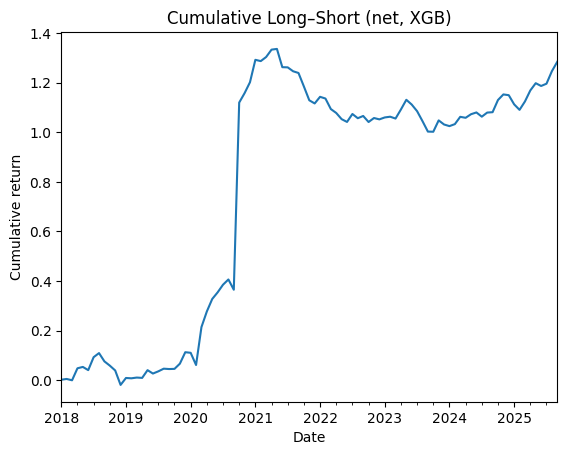

Max drawdown (XGB): -0.334


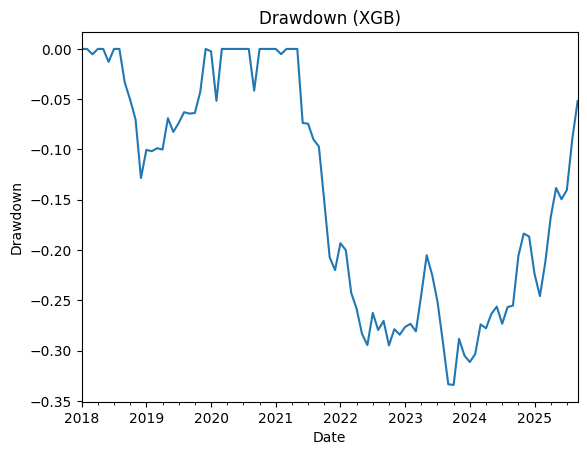

In [515]:
ls_xgb = []

# use scores available up to the penultimate date (predict for dt, hold dt->dt+1)
for dt in scores_xgb.index[:-1]:
    if dt not in y.index:
        continue

    # align predictions and realized returns (same tickers)
    preds = scores_xgb.loc[dt].dropna()
    rets  = y.loc[dt].reindex(preds.index).dropna()
    preds, rets = preds.align(rets, join="inner")

    n = len(preds)
    if n < 10:
        continue

    q = int(0.2 * n)  # top/bottom 20%
    long_names  = preds.nlargest(q).index
    short_names = preds.nsmallest(q).index

    long_ret  = rets.loc[long_names].mean()
    short_ret = rets.loc[short_names].mean()
    spread    = float(long_ret - short_ret)

    ls_xgb.append((dt, spread, set(long_names) | set(short_names)))

ls_xgb = (
    pd.DataFrame(ls_xgb, columns=["Date", "L_S", "names"])
      .set_index("Date")
      .sort_index()
)
ls_xgb["L_S"] = ls_xgb["L_S"].astype(float)

# --- Turnover (fraction of names that changed) ---
turn_xgb = []
prev_xgb = set()
for dt, names in ls_xgb["names"].items():
    cur = names
    chg = 0 if not prev_xgb else 1 - len(prev_xgb & cur) / len(prev_xgb | cur)
    turn_xgb.append((dt, chg))
    prev_xgb = cur

turn_xgb = pd.Series(dict(turn_xgb)).sort_index()

# --- Apply simple costs (align indices!) ---
# 10 bps = 0.001 per "book" turnover (this is a coarse placeholder)
cost_bps = 0.001
net_ls_xgb = ls_xgb["L_S"] - cost_bps * turn_xgb.reindex(ls_xgb.index).fillna(0)

# --- Performance stats ---
sr_denom_xgb = net_ls_xgb.std(ddof=1)
sr_xgb = np.nan if (sr_denom_xgb == 0 or np.isnan(sr_denom_xgb)) else net_ls_xgb.mean() / sr_denom_xgb

print("Avg monthly turnover:", np.round(turn_xgb.mean(), 2))
print("Avg monthly L–S:", np.round(net_ls_xgb.mean(), 4))
print("Sharpe (monthly):", np.round(sr_xgb, 2))

# --- Plot cumulative return ---
ax = net_ls_xgb.cumsum().plot(title="Cumulative Long–Short (net, XGB)")
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative return")
plt.show()

# --- Drawdown plot ---
cum_xgb  = net_ls_xgb.cumsum()
peak_xgb = cum_xgb.cummax()
dd_xgb   = cum_xgb - peak_xgb
print("Max drawdown (XGB):", np.round(dd_xgb.min(), 3))

ax = dd_xgb.plot(title="Drawdown (XGB)")
ax.set_xlabel("Date"); ax.set_ylabel("Drawdown")
plt.show()


In [516]:
bins_all_xgb = []
for dt in scores_xgb.index[:-1]:
    if dt not in y.index:
        continue
    preds = scores_xgb.loc[dt].dropna()
    rets  = y.loc[dt].reindex(preds.index).dropna()
    preds, rets = preds.align(rets, join="inner")
    if len(preds) < 10:
        continue
    qbin = pd.qcut(preds, 5, labels=False, duplicates="drop")
    bins_all_xgb.append(rets.groupby(qbin).mean())

bin_table_xgb = (
    pd.concat(bins_all_xgb, axis=1)
    .mean(axis=1)
    .rename({0:"Q1(low)",1:"Q2",2:"Q3",3:"Q4",4:"Q5(high)"})
)
bin_table_xgb


Q1(low)     0.002205
Q2          0.000653
Q3         -0.001480
Q4         -0.002302
Q5(high)    0.013950
dtype: float64

In [517]:
scores_xgb.to_parquet("../data/scores_xgb.parquet")
ic_xgb.to_frame("IC").to_parquet("../data/ic_xgb.parquet")
ls_xgb["L_S"].to_frame().to_parquet("../data/long_short_monthly_xgb.parquet")
net_ls_xgb.to_frame("L_S_net").to_parquet("../data/long_short_monthly_net_xgb.parquet")
turn_xgb.to_frame("turnover").to_parquet("../data/turnover_xgb.parquet")
print("✅ Saved XGB artifacts")


✅ Saved XGB artifacts


In [518]:
summary_xgb = pd.Series({
    "IC_mean":      ic_xgb.mean(),
    "IC_std":       ic_xgb.std(ddof=1),
    "IC_tstat":     ic_xgb.mean() / (ic_xgb.std(ddof=1) / np.sqrt(ic_xgb.notna().sum())),
    "IC_hit_ratio": (ic_xgb > 0).mean(),
    "LS_mean":      net_ls_xgb.mean(),
    "LS_std":       net_ls_xgb.std(ddof=1),
    "LS_sharpe_m":  net_ls_xgb.mean() / net_ls_xgb.std(ddof=1),
    "Turnover_m":   turn_xgb.mean(),
    "MaxDD":        (net_ls_xgb.cumsum() - net_ls_xgb.cumsum().cummax()).min()
})
summary_xgb.round(3)


IC_mean        -0.008
IC_std          0.092
IC_tstat       -0.821
IC_hit_ratio    0.430
LS_mean         0.014
LS_std          0.085
LS_sharpe_m     0.163
Turnover_m      0.580
MaxDD          -0.334
dtype: float64